# slap_two_layer_neural_network

We show implementation of a two-layer neural network by [Size Linear Algebra Library (SLAP)](http://akabe.github.io/slap/).
It is a high-level wrapper of [Lacaml](https://github.com/mmottl/lacaml), a binding of linear algebra libraries LAPACK and BLAS,
with type-level size checking for vector and matrix operations.
SLAP helps your debug by detecting inconsistency of dimensions

- **at compile time** (instead of runtime) and
- **at higher level** (i.e., at a caller site rather than somewhere deep inside of a call stack).

For example, addition of vectors of different sizes causes a type error at compile time, and dynamic errors such as exceptions do not happen. For most high-level matrix operations, the consistency of sizes is verified statically. (Certain low-level operations, like accesses to elements by indices, need dynamic checks.)

In [1]:
#thread ;;
#require "core,slap,slap.top,slap.ppx,jupyter-archimedes" ;;
#print_depth 3 ;; (* Avoid too deep pretty printing *)
#print_length 30 ;; (* Avoid too long pretty printing *)

Module Archimedes loaded and aliased as A.


In [2]:
open Core ;;
open Slap.Common ;;
open Slap.D ;;

## Dimensions, vectors, and matrics

The dimensions of vectors and matrics have type `'n Slap.Size.t` like `int`,
but type parameter `'n` is the size of itselt as follows:

In [3]:
let input_dim = Slap.Size.two ;;
let hidden_dim = Slap.Size.five ;;
let output_dim = Slap.Size.one ;;

val input_dim : Slap.Size.two Slap.Size.t = 2


val hidden_dim : Slap.Size.five Slap.Size.t = 5


val output_dim : Slap.Size.one Slap.Size.t = 1


Similarly, `('n, 'a) vec` is the type of `'n`-dimensional vectors like:

In [4]:
let x = Vec.make1 input_dim

val x : (Slap.Size.two, 'a) Slap_D.vec = R1 R2
                                          1  1


The second type parameter is a _contiguous or discrete_ flag. For the time being, you do not need to consider it because we only use contiguous matrices.

The matrix type `('m, 'n, 'a) mat` has two dimensional type parameters: `'m`, `'n` are the numbers of rows and columns, respectively.

In [5]:
let a = Mat.random hidden_dim input_dim ;;

val a : (Slap.Size.five, Slap.Size.two, 'a) Slap_D.mat =
            C1        C2
  R1  0.683384  0.683698
  R2  0.903266 -0.321421
  R3  0.600824  0.400497
  R4 -0.845824  0.709542
  R5  0.153864  0.610164


## Prediction

### Single-layer neural networks

Let $\mathbf{x}$ be an input vector of a layer, $\mathbf{W}$ be a weight matrix, and $\mathbf{b}$ be a bias.
Output vector $\mathbf{y}$ is given by

$$\mathbf{y} = \sigma\left( \mathbf{W} \mathbf{x} + \mathbf{b} \right)$$

where $\sigma$ is a sigmoid function defined as

$$\sigma(a) = \frac{1}{1 + \exp(-a)}.$$

A Level-2 BLAS function `gemv ~trans:normal ~alpha a x ~beta ~y` performs
$\mathbf{y} \gets \alpha \mathbf{A} \mathbf{x} + \beta \mathbf{y}$ ($\mathbf{y}$ is destructively modified).
Using `gemv`, we write a prediction function of single-layer neural network:

In [6]:
let sigmoid a = 1.0 /. (1.0 +. exp (~-. a)) ;;
let predict1 w b x = Vec.map sigmoid (gemv ~trans:normal w x ~beta:1.0 ~y:(Vec.copy b)) ;;

val sigmoid : float -> float = <fun>


val predict1 :
  ('a, 'b, 'c) Slap.D.mat ->
  ('a, 'd) Slap_D.vec -> ('b, 'e) Slap.D.vec -> ('a, 'f) Slap_D.vec = <fun>


### Two-layer neural networks

Let $\mathbf{x}$ be an input vector of a layer,
$\mathbf{W}_1, \mathbf{W}_2$ be weight matrices,
and $\mathbf{b}_1, \mathbf{b}_2$ be biases.
Output vector $\mathbf{z}$ is given by

\begin{align*}
  \mathbf{y} & = \sigma\left( \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1 \right), \\
  \mathbf{z} & = \sigma\left( \mathbf{W}_2 \mathbf{y} + \mathbf{b}_2 \right) \\
\end{align*}

where $\mathbf{y}$ is a signal of a hidden layer.

In [7]:
let predict w1 w2 b1 b2 x = predict1 w2 b2 (predict1 w1 b1 x)

val predict :
  ('a, 'b, 'c) Slap.D.mat ->
  ('d, 'a, 'e) Slap.D.mat ->
  ('a, 'f) Slap_D.vec ->
  ('d, 'g) Slap_D.vec -> ('b, 'h) Slap.D.vec -> ('d, 'i) Slap_D.vec = <fun>


## Training

We minimize the root-mean-square (RMS) error

$$E(S) = \frac{1}{2} \sum_{(\mathbf{x}, \mathbf{t}) \in S} \| \mathbf{t} - \mathbf{z}(\mathbf{x}) \|^2$$

on a training set $S$ by backpropagation [Rumelhart, et al. 1986]: we repeatedly update the parameters as follows.

1. Obtain $(\mathbf{x}, \mathbf{t}) \in S$ with replacement.
2. $\mathbf{y} = \sigma\left( \mathbf{W}_1 \mathbf{x} + \mathbf{b}_1 \right)$
3. $\mathbf{z} = \sigma\left( \mathbf{W}_2 \mathbf{y} + \mathbf{b}_2 \right)$
4. $\mathbf{\delta}_2 = (\mathbf{z} - \mathbf{t}) \otimes \mathbf{z} \otimes (\mathbf{1} - \mathbf{z})$
5. $\mathbf{\delta}_1 = \mathbf{W}_2^\top \mathbf{\delta}_2 \otimes \mathbf{y} \otimes (\mathbf{1} - \mathbf{y})$
6. $\mathbf{W}_1 \gets \mathbf{W}_1 - \eta \mathbf{\delta}_1 \mathbf{x}^\top$
7. $\mathbf{W}_2 \gets \mathbf{W}_2 - \eta \mathbf{\delta}_2 \mathbf{y}^\top$
8. $\mathbf{b}_1 \gets \mathbf{b}_1 - \eta \mathbf{\delta}_1$
9. $\mathbf{b}_2 \gets \mathbf{b}_2 - \eta \mathbf{\delta}_2$

where $\eta > 0$ is a learning rate, and $\otimes$ is element-wise multiplication on vectors.

In [8]:
let train ~eta w1 w2 b1 b2 x t =
  let dsigmoid v =
    let ones = Vec.make1 (Vec.dim v) in
    Vec.mul v (Vec.sub ones v)
  in
  let y = Vec.map sigmoid (gemv ~trans:normal w1 x ~beta:1.0 ~y:(Vec.copy b1)) in
  let z = Vec.map sigmoid (gemv ~trans:normal w2 y ~beta:1.0 ~y:(Vec.copy b2)) in
  let delta2 = Vec.mul (Vec.sub z t) (dsigmoid z) in
  let delta1 = Vec.mul (gemv ~trans:trans w2 delta2) (dsigmoid y) in
  ignore (ger ~alpha:(~-. eta) delta2 y w2) ;
  ignore (ger ~alpha:(~-. eta) delta1 x w1) ;
  axpy ~alpha:(~-. eta) b2 delta2 ;
  axpy ~alpha:(~-. eta) b1 delta1

val train :
  eta:float ->
  ('a, 'b, 'c) Slap.D.mat ->
  ('d, 'a, 'e) Slap.D.mat ->
  ('a, 'f) Slap_D.vec ->
  ('d, 'g) Slap_D.vec -> ('b, 'h) Slap.D.vec -> ('d, 'i) Slap_D.vec -> unit =
  <fun>


### Training a random dataset

We use a dataset generated from a bivariate Gaussian distribution
by [random_dataset_generation.ipynb](random_dataset_generation.ipynb).

In [9]:
let dataset =
  let float = float_of_string in
  In_channel.read_lines "datasets/bivariate_gaussian_2d.csv"
  |> List.filter_map ~f:(fun line ->
      match String.split ~on:',' line with
      | [x; y; t] -> Some ([%vec [float x; float y]], [%vec [float t]])
      | _ -> None) ;;

val dataset :
  ((Slap.Size.two, 'a) Slap.D.vec * (Slap.Size.one, 'b) Slap.D.vec)
  Core.List.t =
  [(       R1      R2
    -0.740868 1.08918, R1
                        0);
   (      R1        R2
    -1.37741 -0.485505, R1
                         0);
   (       R1       R2
    -0.727394 0.973983, R1
                         0);
   (       R1      R2
    -0.784392 2.71865, R1
                        0);
   (         R1      R2
    -0.00955137 3.33509, R1
                          0);
   (     R1       R2
    0.34222 0.660543, R1
                       0);
   (       R1        R2
    -0.722362 -0.405427, R1
                          0);
   (      R1       R2
    0.146598 -0.49812, R1
                        0);
   (       R1       R2
    -0.811723 -1.19668, R1
                         0);
   (...); ...]


In [10]:
let (w1, b1, w2, b2) =
  let w1 = Mat.random hidden_dim input_dim in
  let b1 = Vec.random hidden_dim in
  let w2 = Mat.random output_dim hidden_dim in
  let b2 = Vec.random output_dim in
  for i = 0 to 100 do
    List.iter ~f:(fun (x, t) -> train ~eta:1.0 w1 w2 b1 b2 x t) dataset
  done ;
  (w1, b1, w2, b2)

val w1 : (Slap.Size.five, Slap.Size.two, 'a) Slap_D.mat =
             C1        C2
  R1     2.3058 -0.107382
  R2   -3.27364  0.202057
  R3   -3.79329   3.95299
  R4    3.15454 -0.161077
  R5 -0.0032972 0.0913999
val b1 : (Slap.Size.five, 'a) Slap_D.vec =
        R1        R2       R3         R4        R5
  -0.32692 -0.568707 0.773924 -0.0921993 -0.730415
val w2 : (Slap.Size.one, Slap.Size.five, 'a) Slap_D.mat =
          C1       C2       C3      C4       C5
  R1 2.51502 -2.84573 -2.06153 3.77482 0.566059
val b2 : (Slap.Size.one, 'a) Slap_D.vec =      R1
                                          0.18147


### Decision boundary

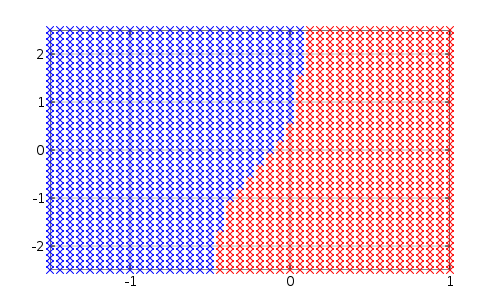

- : unit = ()


In [11]:
let xmin, xmax = -1.5, 1.0 in
let ymin, ymax = -2.5, 2.5 in
let n_samples = 40 in
let vp = A.init ~text:14. ~w:500. ~h:300. ["jupyter"] in
A.Axes.box vp ;
A.Viewport.xrange vp xmin xmax ;
A.Viewport.yrange vp ymin ymax ;
for i = 0 to n_samples do
  let y = float i /. float n_samples *. (ymax -. ymin) +. ymin in
  for j = 0 to n_samples do
    let x = float j /. float n_samples *. (xmax -. xmin) +. xmin in
    let z = predict w1 w2 b1 b2 @@ Vec.of_list_dyn input_dim [x; y] in
    A.set_color vp (if Vec.get_dyn z 1 > 0.5 then A.Color.red else A.Color.blue) ;
    A.List.xy_pairs vp ~style:(`Markers "x") [x, y]
  done
done ;
A.close vp